In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Création des données d'entrainement

Pour créer nos données d'entrainement, nous avons besoin de calculer les fractions volumiques sur 3 mailles à l'aide de la fonction suivante (qui calcule la fraction volumique sur une maille):

In [8]:
def compute_volfrac(X,g,side):
    if side<0:
        if g<np.min(X):
            v_f=0
        elif g>np.max(X):
            v_f=1
        else:
            v_f=g-np.min(X)
    else:
        if g<np.min(X):
            v_f=1
        elif g>np.max(X):
            v_f=0
        else:
            v_f=np.max(X)-g
    return v_f
                
        
    
X=np.array([-0.5,0.5])
g=0.4
f_v=compute_volfrac(X,g,-1)
print(f_v)

0.9


De même, nous devons calculer la quantité de masse exacte sortant par le coté droit de la maille centrale. Pour ceci, nous avons la fonction suivante:

[0.   0.   0.28]


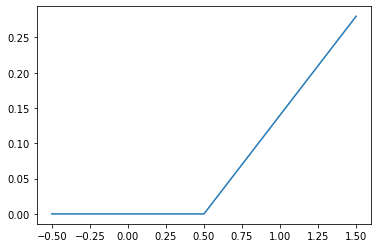

In [9]:
def compute_exact_mass(X,g,side,b):
    Q_m=0
    if b>0:
        if side<0:
            if g+b<=X[1]:
                return(Q_m)
            elif (g+b>X[1])&(g<X[1]):
                Q_m=g+b-X[1]
                return(Q_m)
            else:
                Q_m=b
                return(Q_m)
        else:
            if g+b<=X[1]:
                Q_m=b
                return(Q_m)
            elif (g+b>X[1])&(g<X[1]):
                Q_m=X[1]-g
                return(Q_m)
            else:
                return(Q_m) 
    else:
        if side<0:
            if g<=X[1]:
                Q_m=0
                return(Q_m)
            elif (g+b<X[1])&(g>X[1]):
                Q_m=X[1]-(g+b)
                return(Q_m)
            else:
                Q_m=-b
                return(Q_m)
        else:
            if g+b>=X[1]:
                Q_m=0
                return(Q_m)
            elif (g+b<X[1])&(g>X[1]):
                Q_m=X[1]-g-b
                return(Q_m)
            else:
                Q_m=-b
                return(Q_m)
        
        
g=2.21
b=-0.99       
side=1
X=np.linspace(-0.5,1.5,3)
X_frac=np.linspace(-1.5,0.5,3)
E_m=np.array([])
for i in X_frac:
    Xtemp=np.array([i,i+1])
    E_m=np.append(E_m,compute_exact_mass(Xtemp,g,side,b))
print(E_m)
plt.plot(X,E_m)

Pour finir, la fonction ci-dessous crée un set d'entrainement pour le réseau de neurones: en entrée, un tenseur contenant les fractions volumiques, en sortie un tenseur contenant les quantités de matières passant par les bords droits de chaque mailles.

- Pour les gammas, nous avons fait en sorte que le modèle s'entraine aussi sur des sets où le gamma est extérieur. Nous les avons donc pris entre -2 et 2
- Pour les betas, nous nous sommes contenter de les prendre sur $[0;1]$ dans un premier temps.

In [64]:

def generate_training_data(ngammas,nbetas):
    entree_train = np.zeros((ngammas*nbetas*2,4))
    # J'initialise mes entrées: mes entrées sont les fractions volumiques
    # calculées pour chaque betas, chaques gammas et chaque side
    # il y aura donc ngammas*nbeta*2 vecteurs de tailles 3+1 (on stocke beta aussi)
    label_train = np.zeros((ngammas*nbetas*2,3))
    # J'initialise mes label: mes labels sont les quantités de matières
    # exactes passant par chaque bord de maille: ngammas*nbetas*2 vecteurs 
    # de taille 3
    G = np.random.uniform(-2,2,ngammas)
    # je génère ngammas valeurs de gammas sorties sous la loi unif
    B = np.random.uniform(0,1,nbetas)
    # pareil pour beta
    S=np.array([-1,1])
    # Ca c'est mes sides (-1 ou 1)
    X=np.array([[-1.5,-0.5],[-0.5,0.5],[0.5,1.5]])
    # Ca c'est mes mailles
    i=0
    for g in G:
        j=0
        for b in B:
            k=0
            for s in S:
                Vol=np.array([compute_volfrac(np.array([-1.5,-0.5]),g,s),
                              compute_volfrac(np.array([-0.5,0.5]),g,s),
                              compute_volfrac(np.array([0.5,1.5]),g,s)])
                entree_train[i+j+k,:]=np.append(Vol,b)
                #Je crée une matrice contenant mes sorties
                Mass=np.array([compute_exact_mass(np.array([-1.5,-0.5]),g,s,b),
                               compute_exact_mass(np.array([-0.5,0.5]),g,s,b),
                               compute_exact_mass(np.array([0.5,1.5]),g,s,b)])
                label_train[i+j+k,:]=Mass
                #pareil pour mes labels
                k=k+1
            j=j+k
        i=i+j
    entree_tens = tf.constant(entree_train)
    label_tens = tf.constant(label_train)
    dataset=tf.data.Dataset.from_tensor_slices((entree_tens,label_tens))
    # dataset=tf.data.Dataset.from_tensor_slices((entree_train,label_train))
    # J'en fait direct un tenseur de tensorflow: j'ai galéré un peu à produire
    # un tenseur qui passait dans les entrée du NN, mais maintenant ca colle!
    return(dataset)



In [66]:
batchsize = 100 #Je les regroupe par paquet de 5à, parce que si on veux
#Un nombre de gammas/betas suffisant, les dim explose.
ngammas = 300
nbetas = 200
data_set = generate_training_data(ngammas,nbetas)
data_set = data_set.cache()
data_set = data_set.shuffle(ngammas*nbetas*2)
# Je mélange
data_set = data_set.batch(batchsize).prefetch(tf.data.AUTOTUNE)
# Je batch et prefetch (pour les fans de la cité de la peur:
# "Alors que revoilaaaa la sous prefeeeeetch")
data_set

<PrefetchDataset shapes: ((None, 4), (None, 3)), types: (tf.float64, tf.float64)>

## Création et entrainement du réseau:

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow import keras

Après quelques essais, ce modèle a été le plus efficace:
- 2 couches intermédiaires
- fonctions d'activation relu
- Optimiseur Adam
- loss et metric: MSE

Le modèle a été entrainé sur une centaine d'epochs (le résultat ci dessous n'est pas le modèle final).

In [68]:
#Ne pas compiler

n=4
m=20
model = Sequential()
model.add(Dense(units=2*n,input_dim=4,activation='relu'))
# Première couche: entrée 4 (3FracVol+1Vit)
model.add(Dense(units=4*n,activation='relu'))
model.add(Dense(units=2*n,activation='relu'))

model.add(Dense(units=3,activation='relu'))
#Troisième couche: sortie 3 (3 masse exacte)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 40        
                                                                 
 dense_5 (Dense)             (None, 16)                144       
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 3)                 27        
                                                                 
Total params: 347
Trainable params: 347
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Ne pas compiler

model.compile(optimizer = Adam(learning_rate=1e-3),
             loss = keras.losses.mean_squared_error,
             metrics=[keras.metrics.mean_squared_error])
# Dans le papier qui établi la méthode, ils optimisent avec
# une descente de gradient stochastique, et la fonction loss
# c'est MSE.

In [70]:
# Ne pas compiler
epoch = 100
model.fit(data_set, epochs = epoch, verbose=1)

Epoch 1/100
1200/1200 [==============================] - 1s 673us/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 2/100
1200/1200 [==============================] - 1s 717us/step - loss: 3.2278e-04 - mean_squared_error: 3.2278e-04
Epoch 3/100
1200/1200 [==============================] - 1s 746us/step - loss: 1.5009e-04 - mean_squared_error: 1.5009e-04
Epoch 4/100
1200/1200 [==============================] - 1s 753us/step - loss: 7.6079e-05 - mean_squared_error: 7.6079e-05
Epoch 5/100
1200/1200 [==============================] - 1s 679us/step - loss: 4.9017e-05 - mean_squared_error: 4.9017e-05
Epoch 6/100
1200/1200 [==============================] - 1s 716us/step - loss: 2.6602e-05 - mean_squared_error: 2.6602e-05
Epoch 7/100
1200/1200 [==============================] - 1s 814us/step - loss: 1.4612e-05 - mean_squared_error: 1.4612e-05
Epoch 8/100
1200/1200 [==============================] - 1s 822us/step - loss: 1.0293e-05 - mean_squared_error: 1.0293e-05
Epoch 9/100
1200/1200 [=

KeyboardInterrupt: 

In [5]:
#Compiler

model=keras.models.load_model('model2')

0.2589126461054909
-1
63


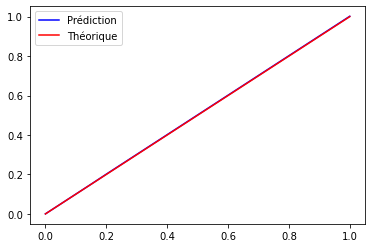

In [15]:
X = np.array([[-1.5,-0.5],[-0.5,0.5],[0.5,1.5]])
g = np.random.uniform(low=-2,high=2,size=1)[0]
B = np.linspace(0,1,21)
print(g)
side = (-1)**(np.random.randint(0,2))
print(side)
m_d_tot=np.array([])
mass_pred_tot=np.array([[]])
for b in B:
    f_v=np.array([])
    m_d=np.array([])
    mass_pred=np.array([])
    for x in X:
        f_v_temp = compute_volfrac(x,g,side)
        #mass_pred = np.append(mass_pred,model.predict(f_v_temp1.reshape(1,2)))
        f_v = np.append(f_v,f_v_temp)
        m_d = np.append(m_d,compute_exact_mass(x,g,side,b))
    mass_pred=model.predict(np.append(f_v,b).reshape(1,4))
    
    m_d_tot = np.append(m_d_tot,m_d)
    mass_pred_tot = np.append(mass_pred_tot,[[mass_pred]])

print(len(mass_pred_tot))
#print(m_d_tot)
# Je créé ma sortie exacte
#fig=plt.figure(figsize=(5,5))
#ax=fig.add_subplot(111)
#ax.scatter(Xplot,m_d,c='b',marker="o")
#ax.scatter(Xplot,mass_pred,c='r',marker="+")
fig = plt.figure()
fig.set_facecolor('white')
plt.plot(B, mass_pred_tot[0::3], color='blue', label='Prédiction')
plt.plot(B,m_d_tot[0::3] , color='red', label='Théorique')
plt.legend()
plt.show()
#Et... certains paramètre ont un comportement bizarre quand la vitesse est proche de 1

In [91]:
model.save('model2')

INFO:tensorflow:Assets written to: model2\assets
